#SQL Querry

-- List of identified ICD codes related to HAI
WITH HAI_ICD_Patients AS (
    SELECT DISTINCT subject_id, hadm_id
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
    WHERE icd_code IN (
        'B952', 'B9561', 'T814XXA', 'A047', 'A0472', 'B9562',
        'J95851', 'B957', 'T8131XA', 'B954', 'T80211A', 'J95811',
        'B951', 'T8132XA', 'T8119XA', 'T8089XA', 'A0471', 'T8189XA',
        'J95821', 'J9589'
    )
),

-- Extract demographics and admission details
PatientDetails AS (
    SELECT p.subject_id, p.gender, p.anchor_age AS age,
           a.hadm_id, a.admission_type, a.admission_location, a.admittime, a.dischtime, a.deathtime
    FROM `physionet-data.mimiciv_hosp.patients` p
    JOIN `physionet-data.mimiciv_hosp.admissions` a ON p.subject_id = a.subject_id
    JOIN HAI_ICD_Patients h ON a.subject_id = h.subject_id AND a.hadm_id = h.hadm_id
),

-- Extract clinical notes
RelevantNotes AS (
    SELECT n.subject_id, n.hadm_id, n.charttime, n.text
    FROM `physionet-data.mimiciv_note.discharge` n
    WHERE n.subject_id IN (SELECT subject_id FROM HAI_ICD_Patients)
    UNION ALL
    SELECT r.subject_id, r.hadm_id, r.charttime, r.text
    FROM `physionet-data.mimiciv_note.radiology` r
    WHERE r.subject_id IN (SELECT subject_id FROM HAI_ICD_Patients)
)

-- Combine the information for EDA
SELECT pd.subject_id, pd.gender, pd.age, pd.hadm_id, pd.admission_type,
       pd.admission_location, pd.admittime, pd.dischtime, pd.deathtime,
       rn.charttime, rn.text
FROM PatientDetails pd
LEFT JOIN RelevantNotes rn ON pd.subject_id = rn.subject_id AND pd.hadm_id = rn.hadm_id
ORDER BY pd.subject_id, pd.hadm_id;


In [1]:
# Importing neccassary libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

#plt.style.use('ggplot')
#plt.rcParams.update({'font.size': 20})


In [2]:
df = pd.read_csv('/Users/mohit88/DataspellProjects/pythonProject/venv/dataset/bq-results-20231010-222825-1696976997847.csv')

df.head()

,subject_id,gender,age,hadm_id,admission_type,admission_location,admittime,dischtime,deathtime,charttime,text
0,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-21 11:36:00,INDICATION: ___ year old woman with subclavia...
1,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-24 05:45:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...
2,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-28 21:18:00,INDICATION: ___ year old woman with wheezing....
3,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-24 06:20:00,EXAMINATION: DUPLEX DOPP ABD/PEL\n\nINDICATIO...
4,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-20 17:57:00,EXAMINATION: Chest radiograph.\n\nINDICATION:...


In [3]:
import pandas as pd

# Replace NaNs in the 'text' column with an empty string
df['text'] = df['text'].fillna("")

# Now, you can safely apply string methods to the 'text' column
df['text_lower'] = df['text'].str.lower()

# Filter rows where text contains relevant keywords for HAI
keywords = ['infection', 'sepsis', 'pneumonia', 'bacteria', 'culture']
mask = df['text_lower'].apply(lambda x: any(keyword in x for keyword in keywords))
df_hai_relevant = df[mask]


/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_28697/1869519450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hai_relevant['word_count'] = df_hai_relevant['text'].apply(lambda x: len(str(x).split()))


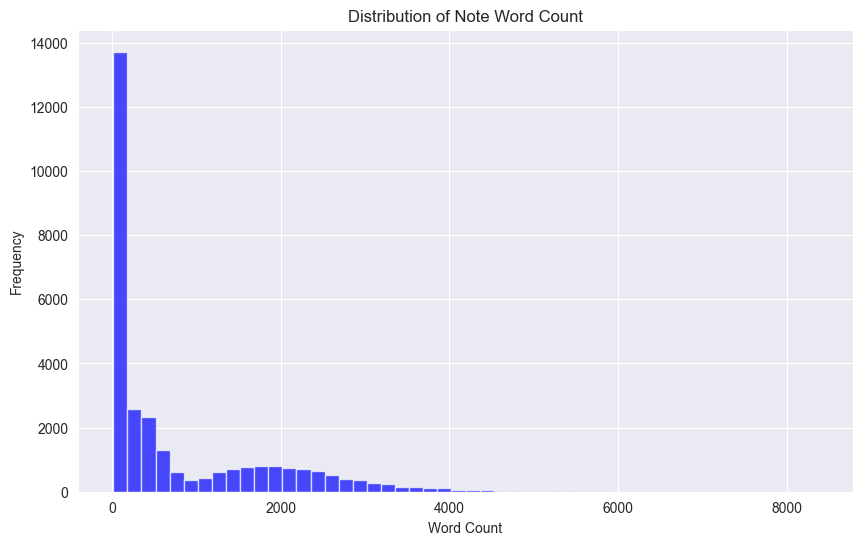

In [4]:
import matplotlib.pyplot as plt

# Calculate the word count for each note
df_hai_relevant['word_count'] = df_hai_relevant['text'].apply(lambda x: len(str(x).split()))

# Plotting the word count
plt.figure(figsize=(10, 6))
plt.hist(df_hai_relevant['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Note Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [6]:
# Create flags for certain terms to identify cohorts
keywords_cohort = ['infection', 'sepsis', 'pneumonia', 'bacteria', 'antibiotic', 'fever']

for keyword in keywords_cohort:
    df_hai_relevant[keyword] = df_hai_relevant['text_lower'].apply(lambda x: 1 if keyword in x else 0)

# Summarize patients based on these flags
patient_cohorts = df_hai_relevant.groupby('subject_id')[keywords_cohort].sum()

# Example: Getting patients who have notes mentioning 'pneumonia'
pneumonia_patients = patient_cohorts[patient_cohorts['pneumonia'] > 0]


/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_28697/2414641785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hai_relevant[keyword] = df_hai_relevant['text_lower'].apply(lambda x: 1 if keyword in x else 0)
/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_28697/2414641785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hai_relevant[keyword] = df_hai_relevant['text_lower'].apply(lambda x: 1 if keyword in x else 0)
/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel

In [8]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download the stopwords and wordnet from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

df_hai_relevant['text_clean'] = df_hai_relevant['text'].apply(clean)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohit88/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mohit88/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/6z/h21x9bt13_zdtt67m39c4_5w0000gn/T/ipykernel_28697/874181925.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hai_relevant['text_clean'] = df_hai_relevant['text'].apply(clean)


In [9]:
# Create the term document matrix
tokenized_text = [text.split() for text in df_hai_relevant['text_clean']]
dictionary = corpora.Dictionary(tokenized_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_text]


In [10]:
# Number of topics you want to extract
num_topics = 5

# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


In [11]:
# Print the topics and words associated with them
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.018*"mg" + 0.015*"po" + 0.014*"pain" + 0.011*"discharge" + 0.010*"patient"')
(1, '0.017*"culture" + 0.016*"final" + 0.015*"right" + 0.012*"left" + 0.012*"1"')
(2, '0.013*"right" + 0.012*"ct" + 0.011*"left" + 0.011*"normal" + 0.011*"cm"')
(3, '0.034*"chest" + 0.024*"right" + 0.021*"effusion" + 0.020*"pleural" + 0.018*"left"')
(4, '0.016*"po" + 0.015*"mg" + 0.013*"blood" + 0.008*"daily" + 0.008*"1"')


In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Note: This might take a while on large datasets
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis


/Users/mohit88/opt/anaconda3/envs/newConda/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.161686 -0.105799       1        1  51.756629
0     -0.249525 -0.062345       2        1  20.171621
2      0.171138 -0.030233       3        1  13.515589
3      0.252774 -0.094057       4        1   8.284345
1     -0.012700  0.292434       5        1   6.271816, topic_info=         Term           Freq          Total Category  logprob  loglift
302     chest   67008.000000   67008.000000  Default  30.0000  30.0000
948     right  108990.000000  108990.000000  Default  29.0000  29.0000
654      left  104022.000000  104022.000000  Default  28.0000  28.0000
369   culture   45523.000000   45523.000000  Default  27.0000  27.0000
722        mg  196057.000000  196057.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
1138     vein    4661.479812   12845.714858   Topic5  -5.4283   1.7554
969      seen    5361.912643   40716.366437   Topic5  -5.2883   0.7418
2030       dr    4566.622173   14986.627262   Topic5  -5.4488   1.5807
491   finding    4720.927003   33164.638388   Topic5  -5.4156   0.8196
48          2    4951.736611   88685.904657   Topic5  -5.3679  -0.1163

[428 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
6         1  0.329776    05
6         2  0.076898    05
6         3  0.248643    05
6         5  0.344639    05
17        1  0.549612     1
...     ...       ...   ...
1178      2  0.068964  year
1178      3  0.128693  year
1178      4  0.587851  year
1178      5  0.082564  year
1664      2  0.999768     •

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

In [14]:
df.head()

,subject_id,gender,age,hadm_id,admission_type,admission_location,admittime,dischtime,deathtime,charttime,text,text_lower
0,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-21 11:36:00,INDICATION: ___ year old woman with subclavia...,indication: ___ year old woman with subclavia...
1,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-24 05:45:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,examination: chest (portable ap)\n\nindicatio...
2,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-28 21:18:00,INDICATION: ___ year old woman with wheezing....,indication: ___ year old woman with wheezing....
3,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-24 06:20:00,EXAMINATION: DUPLEX DOPP ABD/PEL\n\nINDICATIO...,examination: duplex dopp abd/pel\n\nindicatio...
4,15078112,F,70,28224974,ELECTIVE,PHYSICIAN REFERRAL,2178-07-20 13:35:00,2178-08-20 16:53:00,NaN,2178-07-20 17:57:00,EXAMINATION: Chest radiograph.\n\nINDICATION:...,examination: chest radiograph.\n\nindication:...
